In [ ]:
# !export http_proxy="http://127.0.0.1:7890"
# !export https_proxy="http://127.0.0.1:7890"

In [1]:
import json
import os

In [2]:
dataset_path="/re_id/"
current_path = os.getcwd()
imgs_path = os.path.join(current_path,"data_storage/CUHK-PEDES/imgs")
json_path = "data_storage/CUHK-PEDES/caption_all.json"
json_path_os=os.path.join(current_path,json_path)
# 读取 JSON 文件
with open(json_path_os, 'r', encoding='utf-8') as file:
    data = json.load(file)
print(data[0])

{'id': 1, 'file_path': 'test_query/p10376_s14337.jpg', 'captions': ['She wears a purple long sleeved, ankle length dress. There is a pattern on the dress.', 'This woman is heavy set. She is facing to the left of the camera. She is wearing an ankle length dress and is carrying something in her hand. She has her head down.']}


In [3]:
from PIL import Image
import requests
import torch
from torchvision import transforms
from torchvision.transforms.functional import InterpolationMode
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')


In [ ]:

from torchvision.transforms import InterpolationMode
import matplotlib.pyplot as plt


def load_images(image_paths, image_size, device):
    images = []
    
    transform = transforms.Compose([
        transforms.Resize((image_size, image_size), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize((0.48145466, 0.4578275, 0.40821073), (0.26862954, 0.26130258, 0.27577711))
    ])
    for path in image_paths:
        raw_image = Image.open(os.path.join(imgs_path, path)).convert('RGB')
        # Transform and add to list
        image = transform(raw_image).unsqueeze(0).to(device)
        images.append(image)
    

    
    # 将所有图像组合成一个 Tensor
    images = torch.cat(images, dim=0)
    return images

In [5]:
re_id_raw_json="data_storage/CUHK-PEDES/reid_raw.json"
re_id_raw_json_os=os.path.join(current_path,re_id_raw_json)
with open(re_id_raw_json, 'r', encoding='utf-8') as file:
    data_re_id = json.load(file)
print(*(i for i in data_re_id[0:8]), sep="\n")

{'split': 'train', 'captions': ['A pedestrian with dark hair is wearing red and white shoes, a black hooded sweatshirt, and black pants.', 'The person has short black hair and is wearing black pants, a long sleeve black top, and red sneakers.'], 'file_path': 'CUHK01/0363004.png', 'processed_tokens': [['a', 'pedestrian', 'with', 'dark', 'hair', 'is', 'wearing', 'red', 'and', 'white', 'shoes', 'a', 'black', 'hooded', 'sweatshirt', 'and', 'black', 'pants'], ['the', 'person', 'has', 'short', 'black', 'hair', 'and', 'is', 'wearing', 'black', 'pants', 'a', 'long', 'sleeve', 'black', 'top', 'and', 'red', 'sneakers']], 'id': 1}
{'split': 'train', 'captions': ['A man wearing a black jacket, black pants, red, black and white shoes and a gray shirt under his jacket.', 'The man wears a white and black shirt ,black pants with red and white sneakers he walks holding an item inside his hand.'], 'file_path': 'CUHK01/0363003.png', 'processed_tokens': [['a', 'man', 'wearing', 'a', 'black', 'jacket', 'bl

In [6]:
mini_sample=data_re_id[0:8]
mini_sample_path=[i['file_path'] for i in mini_sample]
mini_sample_id=[i['id'] for i in mini_sample]

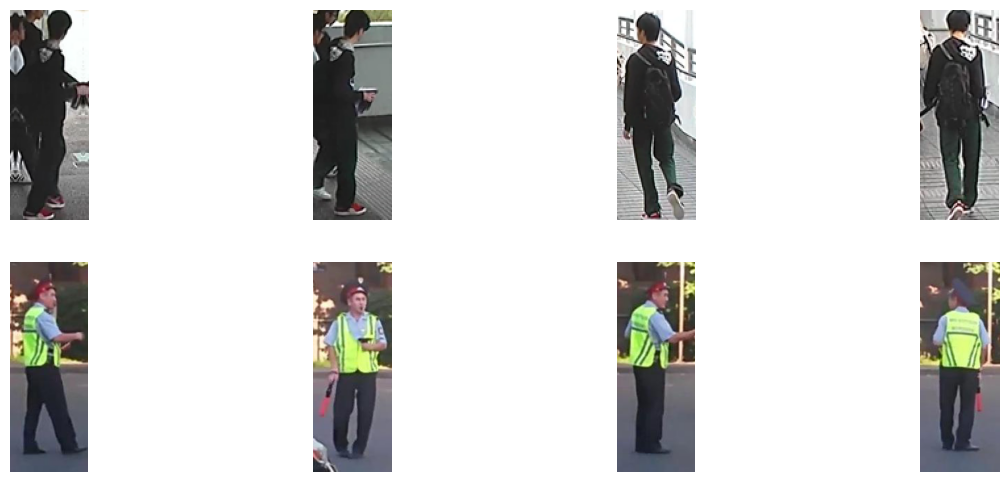

In [21]:
image_size = 384 #这个怎么算的?
images=load_images(mini_sample_path, image_size, device)

In [ ]:
from models.blip import blip_decoder

image_size = 384
image = images

model_url = 'https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth'
    
model = blip_decoder(pretrained=model_url, image_size=image_size, vit='base')
model.eval()
model = model.to(device)

with torch.no_grad():
    # beam search
    caption = model.generate(image, sample=False, num_beams=3, max_length=20, min_length=5) 
    # nucleus sampling
    # caption = model.generate(image, sample=True, top_p=0.9, max_length=20, min_length=5) 
    # print('caption:\n' + '\n'.join(caption))



reshape position embedding from 196 to 576
load checkpoint from https://storage.googleapis.com/sfr-vision-language-research/BLIP/models/model_base_capfilt_large.pth
caption:
a group of people dancing in the street
a man in a black jacket and red shoes
a man running on a bridge
a man walking down the street
a person walking down the street
a man in a police uniform
a police officer
a police officer walking down a street


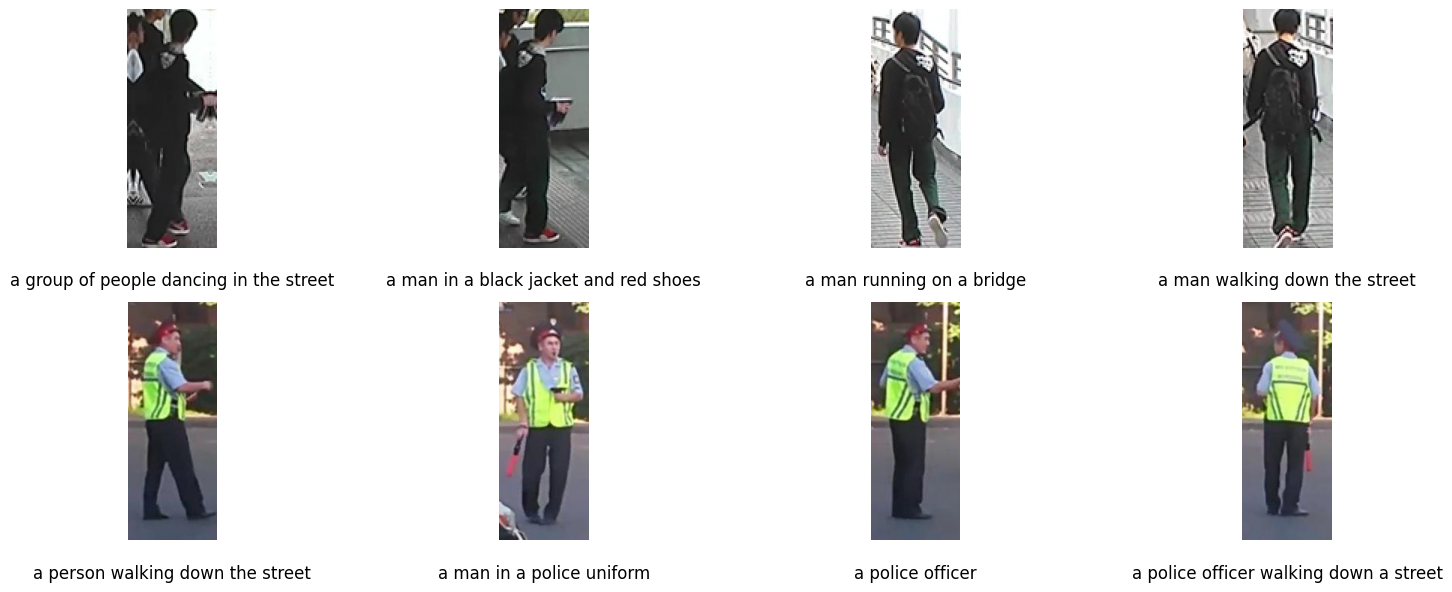

In [22]:
imgs = []  # 用来展示的图片列表
captions=caption
for path in mini_sample_path:
    raw_image = Image.open(os.path.join(imgs_path, path)).convert('RGB')
    imgs.append(raw_image)

num_per_row = 4  # 每行显示的图片数量
rows = len(imgs) // num_per_row + int(len(imgs) % num_per_row > 0)  # 计算行数
fig, axes = plt.subplots(rows, num_per_row, figsize=(15, rows * 3))
axes = axes.flatten()  # 将 axes 转换为 1D 列表方便索引

for i, (img, caption) in enumerate(zip(imgs, captions)):
    axes[i].imshow(img)
    axes[i].axis('off')  # 隐藏坐标轴
    # 添加 caption
    axes[i].text(0.5, -0.1, caption, ha='center', va='top', fontsize=12, transform=axes[i].transAxes)

# 隐藏多余的子图
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()  # 自动调整子图间距
plt.show()